In [1]:
# !pip install "transformers==4.34.0" "datasets[s3]==2.13.0" "sagemaker>=2.190.0" "gradio==3.50.2" --upgrade --quiet

In [2]:
# from accelerate.utils import write_basic_config

# write_basic_config()

In [3]:
import sagemaker
import boto3
import os
from sagemaker.huggingface import HuggingFace

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
sess = sagemaker.Session()
sagemaker_session_bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
# !pwd
# !ls

In [6]:
s3 = boto3.resource('s3')
client = s3.meta.client

In [7]:
local_directory = 'riobugger_cat'
destination = 'training-diffusion'
bucket = sess.default_bucket()

In [8]:
training_input_path = f's3://{sess.default_bucket()}/{destination}'

In [9]:
def upload_folder(local_directory, destination):
    for root, dirs, files in os.walk(local_directory):
        for filename in files:
            # construct the full local path
            local_path = os.path.join(root, filename)
            # construct the full Dropbox path
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(destination, relative_path)
            # relative_path = os.path.relpath(os.path.join(root, filename))
            print('Searching "%s" in "%s"' % (s3_path, bucket))
            try:
                client.head_object(Bucket=bucket, Key=s3_path)
                print("Path found on S3! Skipping %s..." % s3_path)
                # try:
                # client.delete_object(Bucket=bucket, Key=s3_path)
                # except:
                # print("Unable to delete %s..." % s3_path)
            except:
                print("Uploading %s..." % s3_path)
                client.upload_file(local_path, bucket, s3_path)

In [10]:
list(s3.Bucket(bucket).objects.all())

[s3.ObjectSummary(bucket_name='sagemaker-eu-north-1-564976835481', key='huggingface-pytorch-training-2023-11-28-07-30-02-735/debug-output/training_job_end.ts'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-north-1-564976835481', key='huggingface-pytorch-training-2023-11-28-07-30-02-735/output/model.tar.gz'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-north-1-564976835481', key='huggingface-pytorch-training-2023-11-28-07-30-02-735/profiler-output/framework/training_job_end.ts'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-north-1-564976835481', key='huggingface-pytorch-training-2023-11-28-07-30-02-735/profiler-output/system/incremental/2023112807/1701156660.algo-1.json'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-north-1-564976835481', key='huggingface-pytorch-training-2023-11-28-07-30-02-735/profiler-output/system/incremental/2023112807/1701156720.algo-1.json'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-north-1-564976835481', key='huggingface-pytorch-training-2023-11-28-07-30-02-73

In [11]:
# s3.Object(bucket, 'key').delete()

In [12]:
# !python scripts/train_dreambooth.py \
# --class_data_dir="/opt/ml/input/data/class_data" \
# --class_prompt "a photo of cat"\
# --gradient_accumulation_steps 1 \
# --instance_data_dir "/opt/ml/input/data/training"\
# --instance_prompt "a photo of sks cat"\
# --learning_rate 5e-06\
# --lr_scheduler "constant"\
# --lr_warmup_steps 0 \
# --max_train_steps 800 \
# --num_class_images 200 \
# --num_train_epochs 1 \
# --output_dir "/opt/ml/model/" \
# --pretrained_model_name_or_path "CompVis/stable-diffusion-v1-4"\
# --prior_loss_weight 1.0\
# --resolution 512 \
# --train_batch_size 1 \
# --with_prior_preservation

In [13]:
hyperparameters = {
    'pretrained_model_name_or_path': "CompVis/stable-diffusion-v1-4",          # pre-trained model
    'instance_data_dir': '/opt/ml/input/data/training',                        # path where sagemaker will save training dataset
    'num_train_epochs': 1,                                                     # number of training epochs
    'class_data_dir': '/opt/ml/input/data/class_data',                         # class images for prior preservation
    'train_batch_size': 1,                                                     # batch size for training
    'gradient_accumulation_steps': 1,                                          # Number of updates steps to accumulate
    'output_dir': '/opt/ml/model',                                             # output directory, where to save assets during training
    'use_8bit_adam': True,                                                     #
    'with_prior_preservation': True,                                           # 
    'prior_loss_weight': 1.0,                                                  # 
    'instance_prompt': "a_photo_of_sks_cat",                                   # 
    'class_prompt': "a_photo_of_cat",                                          # 
    'resolution': 512,                                                         # 
    "lr_scheduler":"constant",                                                 # learning rate scheduler
    'learning_rate': 5e-6,                                                     # 
    "lr_warmup_steps": 0,                                                      # warmup steps
    'num_class_images': 200,                                                   # 
    'max_train_steps': 800,                                                    # 
}

In [14]:
# /home/ec2-user/.cache/huggingface/accelerate/default_config.yaml

In [15]:
# huggingface_estimator = HuggingFace(
#         entry_point='train_dreambooth.py',
#         source_dir='./scripts',
#         instance_type='ml.g4dn.xlarge',
#         instance_count=1,
#         role=role,
#         transformers_version = '4.28',            # the transformers version used in the training job
#         pytorch_version      = '2.0',             # the pytorch_version version used in the training job
#         py_version           = 'py310',           # the python version used in the training job
#         disable_output_compression = True         # not compress output to save training time and cost
#         hyperparameters = hyperparameters
# )

In [16]:
# huggingface_estimator.fit({'training': training_input_path})

# Deploy

In [17]:
model_uri = 's3://sagemaker-eu-north-1-564976835481/huggingface-pytorch-training-2023-11-28-07-30-02-735/output/model.tar.gz'

In [18]:
url_parts = model_uri.split("/")  # => ['s3:', '', 'sagemakerbucketname', 'data', ...
# bucket_name = url_parts[2]
key = os.path.join(*url_parts[3:])
filename = url_parts[-1]

- Download
- Unzip
- Add code/(requirement.txt, inference.py)
- Zip
- Upload

In [19]:
s3.Bucket(bucket).download_file(key, filename)

In [20]:
import tarfile
import os

In [21]:
!ls

1-prepare-data.ipynb  lost+found  model.tar.gz	riobugger_cat  scripts


In [22]:
os.makedirs('model_extracted', exist_ok=True)
file = tarfile.open('model.tar.gz')
file.extractall('model_extracted')
file.close()

In [23]:
!mkdir code

In [24]:
%%writefile code/requirements.txt
git+https://github.com/huggingface/diffusers
transformers>=4.25.1

Writing code/requirements.txt


In [25]:
%%writefile code/inference.py
import base64
import torch
from io import BytesIO
from diffusers import StableDiffusionPipeline


def model_fn(model_dir):
    # Load stable diffusion and move it to the GPU
    pipe = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float16)
    pipe = pipe.to("cuda")

    return pipe


def predict_fn(data, pipe):

    # get prompt & parameters
    prompt = data.pop("inputs", data)
    # set valid HP for stable diffusion
    num_inference_steps = data.pop("num_inference_steps", 50)
    guidance_scale = data.pop("guidance_scale", 7.5)
    num_images_per_prompt = data.pop("num_images_per_prompt", 4)

    # run generation with parameters
    generated_images = pipe(
        prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        num_images_per_prompt=num_images_per_prompt,
    )["images"]

    # create response
    encoded_images = []
    for image in generated_images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())

    # create response
    return {"generated_images": encoded_images}

Writing code/inference.py


In [26]:
from distutils.dir_util import copy_tree
copy_tree("code/", os.path.join('model_extracted', 'code'))

['model_extracted/code/inference.py', 'model_extracted/code/requirements.txt']

In [27]:
!mv model.tar.gz model.tar.gz_backup

In [28]:
import tarfile
import os

# helper to create the model.tar.gz
def compress(tar_dir=None, output_file="model.tar.gz"):
    parent_dir=os.getcwd()
    os.chdir(tar_dir)
    with tarfile.open(os.path.join(parent_dir, output_file), "w:gz") as tar:
        for item in os.listdir('.'):
            print(item)
            tar.add(item, arcname=item)
    os.chdir(parent_dir)

compress(str('model_extracted'))

feature_extractor
text_encoder
model_index.json
logs
vae
unet
safety_checker
scheduler
checkpoint-500
tokenizer
code


In [29]:
from sagemaker.s3 import S3Uploader

# upload model.tar.gz to s3
s3_model_uri=S3Uploader.upload(local_path="model.tar.gz", desired_s3_uri=f"s3://{sess.default_bucket()}/diffusion_dreambooth_sks_cat")

print(f"model uploaded to: {s3_model_uri}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
model uploaded to: s3://sagemaker-eu-north-1-564976835481/diffusion_dreambooth_sks_cat/model.tar.gz


In [30]:
from sagemaker.huggingface.model import HuggingFaceModel


# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version='4.28',  # transformers version used
   pytorch_version='2.0',        # pytorch version used
   py_version='py310',           # python version used
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [31]:
# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )

----------!

In [33]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64
import matplotlib.pyplot as plt

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

# display PIL images as grid
def display_images(images=None,columns=3, width=100, height=100):
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

Matplotlib is building the font cache; this may take a moment.


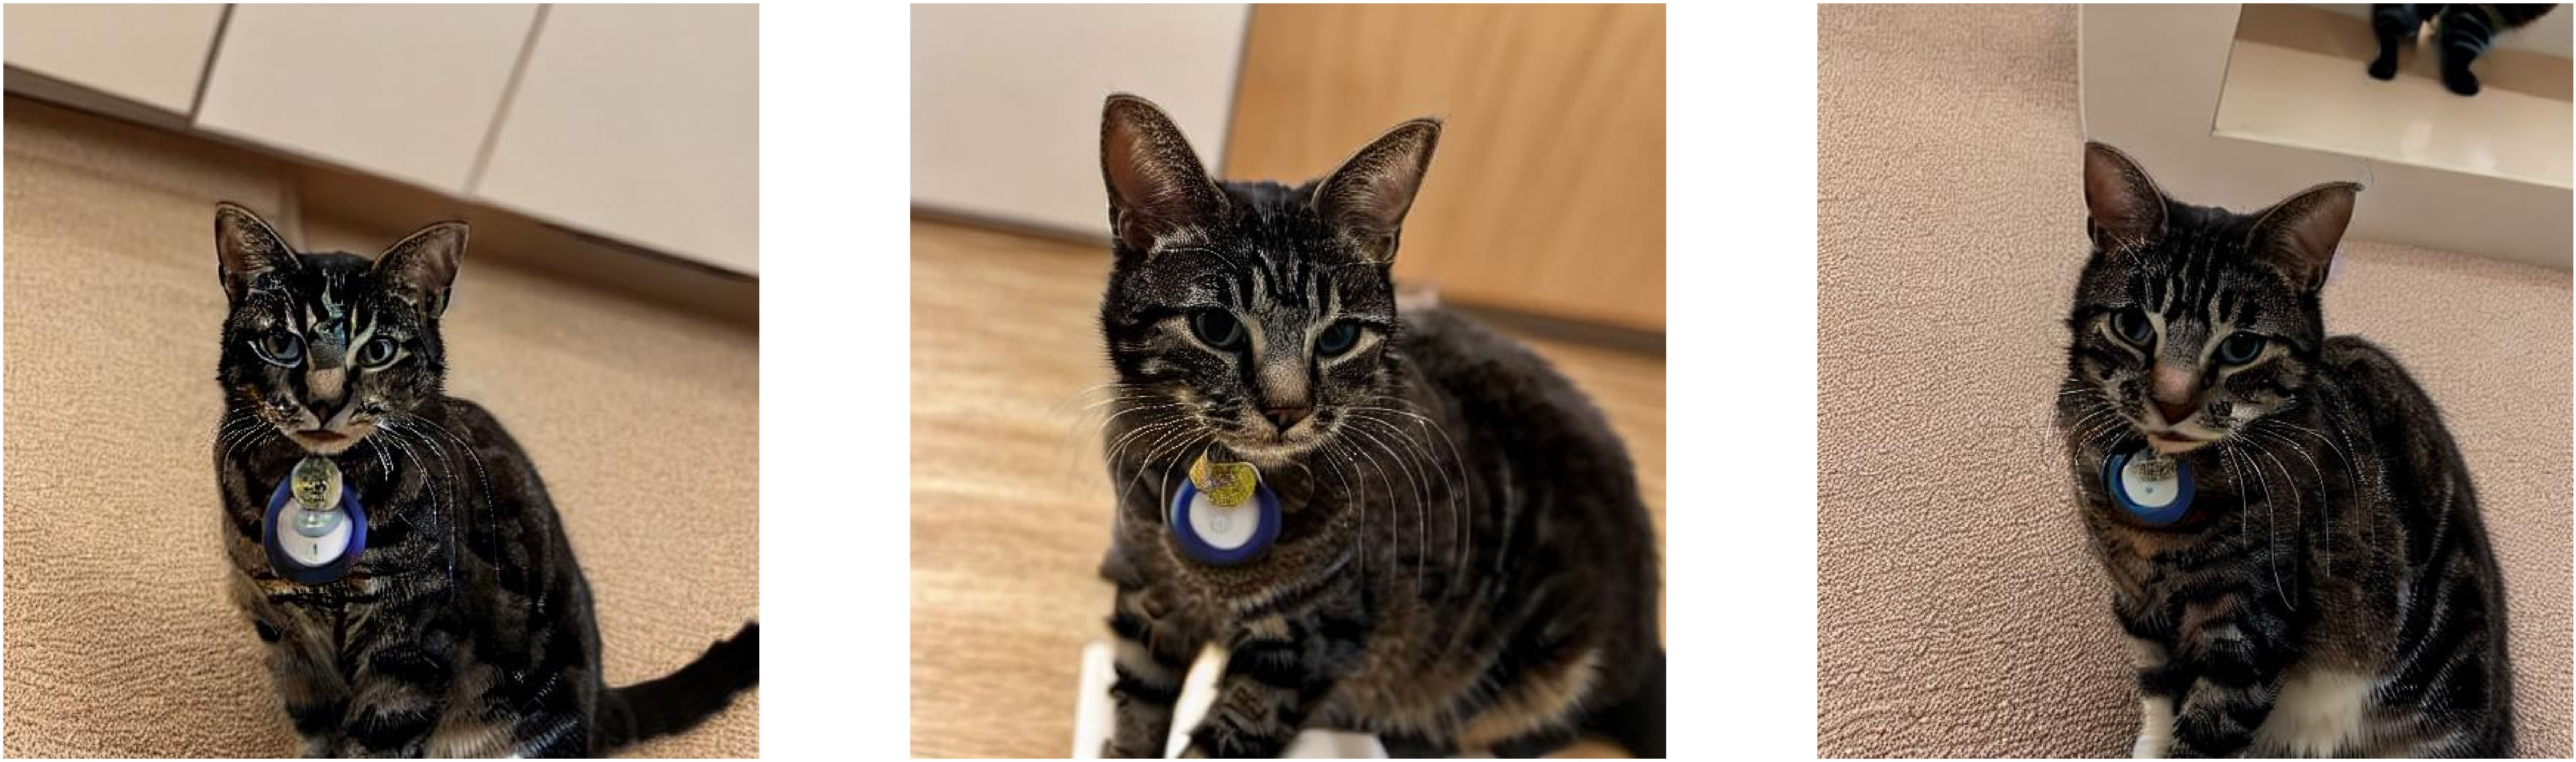

In [40]:
num_images_per_prompt = 3
prompt = "a photo of sks cat"

# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "num_images_per_prompt" : num_images_per_prompt
  }
)

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
display_images(decoded_images)

In [41]:
predictor.delete_model()
predictor.delete_endpoint()